<a href="https://colab.research.google.com/github/dirknbr/numpyro-examples/blob/main/numypro_local_trend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimate a time varying parameter in numpyro

$y_t \sim N(\mu_t, \sigma)$

where mu has a random walk

$\mu_t \sim N(\mu_{t-1}, 1)$

We initialise

$\mu_0 \sim N(10, 1)$

which informs the first $\mu_1$


In [ ]:
!pip install numpyro

In [ ]:
# http://num.pyro.ai/en/latest/tutorials/time_series_forecasting.html

import numpy as np
import jax.numpy as jnp
from jax import random
import arviz

import numpyro
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan
from numpyro.diagnostics import autocorrelation, hpdi
from numpyro.infer import MCMC, NUTS, Predictive


# after 5 we go up

y = np.random.normal(10, 1, size=10) + 2 * (np.arange(10) >= 5)

# http://num.pyro.ai/en/stable/primitives.html

def model(y=None):
  # mu = numpyro.sample('mu', dist.Normal(0, 10))
  sigma = numpyro.sample('sigma', dist.Gamma(2, 1))
  def trans_fn(prev, y_cur):
    mu = numpyro.sample('mu', dist.Normal(prev, 1))
    y_cur = numpyro.sample('obs', dist.Normal(mu, sigma), obs=y_cur)
    return mu, (mu, y_cur)
  mu0 = numpyro.sample('mu0', dist.Normal(10, 10))
  _, (mu, y) = scan(trans_fn, mu0, y, length=10)
  return mu, y


In [ ]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=1000, num_chains=2)
mcmc.run(random.PRNGKey(0), y)
mcmc.print_summary()
samples = mcmc.get_samples()

/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:280: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 1500/1500 [00:00<00:00, 5843.80it/s, 15 steps of size 3.18e-01. acc. prob=0.90]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     mu[0]      9.74      0.73      9.81      8.53     10.85   1013.55      1.00
     mu[1]      9.20      0.64      9.16      8.15     10.22   1017.74      1.00
     mu[2]      8.70      0.71      8.61      7.68      9.90    623.59      1.00
     mu[3]      9.20      0.65      9.12      8.16     10.26    900.61      1.00
     mu[4]     10.11      0.63     10.08      9.08     11.18   1684.86      1.00
     mu[5]     11.65      0.75     11.72     10.44     12.78    548.94      1.00
     mu[6]     11.39      0.64     11.38     10.33     12.39   1361.48      1.00
     mu[7]     11.56      0.62     11.55     10.66     12.68   1275.96      1.00
     mu[8]     11.99      0.69     12.09     10.87     13.05   1033.46      1.00
     mu[9]     11.52      0.77     11.48     10.29     12.78   1364.81      1.00
       mu0      9.75      1.22      9.78      7.70     11.65   1491.46      1.00
     sigma      0.87      0

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa04f055f50>],
      dtype=object)

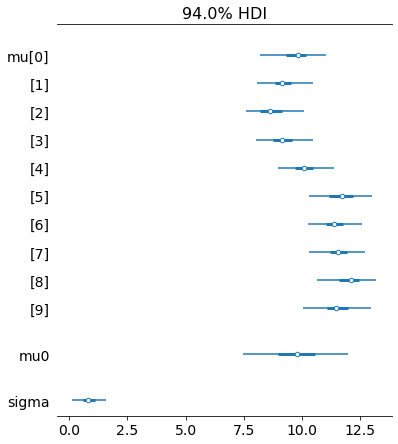

In [ ]:
inf = arviz.from_numpyro(mcmc)
arviz.plot_forest(inf, combined=True)